# Анализ работы API (CPU vs GPU)

In [1]:
import os
import requests
from sentence_splitter import SentenceSplitter, split_text_into_sentences
import time

## Множество одновременных обращений к API

In [2]:
def en_ru(title='************'):
    sourceid="en"
    targetid="ru"
    source = f'input.{sourceid}'
    target = f'api-output.en-{targetid}'
    url = 'http://10.239.16.89:60001/api/translation' 
    headers = {'accept': 'application/json',
               'Content-Type': 'application/json',
    }
    with open(source, encoding='utf-8') as f:
        text = f.readlines()
    text = (" ".join([i.strip() for i in text]))
    text = split_text_into_sentences(text, language=sourceid)

    result = []
    n = 0
    all_time = 0
    for sent in text:
        start = time.time() # начало замера времени
        n += 1
        sent = sent.replace('"', '\\"').encode('ascii', errors='ignore').decode("utf-8")
        data = '{ \"text\": \"'+sent+'\", \"sourceLanguage\": \"'+sourceid+'\", \"targetLanguage\": \"'+targetid+'\"}'
        answer = requests.post(url, headers=headers, data=data).json()['message']        
        end = time.time() # окончание замера времени
        all_time += (end - start) # фиксация затраченного времени
        result.append(answer)

#     print('EN-RU\n', title)
#     print(f'Затрачено времени: {all_time:.2f} сек.')
    return all_time


In [3]:
def ar_ru(title='************'):
    sourceid="ar"
    targetid="ru"
    source = f'input.{sourceid}'
    target = f'api-output.en-{targetid}'
    url = 'http://10.239.16.89:60001/api/translation' 
    headers = {'accept': 'application/json',
               'Content-Type': 'application/json',
    }

    result = []
    all_time = 0
    with open(source, encoding='utf-8') as f:
        n = 0
        for i in f:
            start = time.time() # начало замера времени
            sent = i.strip()
            n += 1
            sent = sent.encode('utf-8').decode('latin-1', 'ignore')
            data = '{\n  "text": "' + str(sent) + '",\n  "sourceLanguage": "' + sourceid + '",\n  "targetLanguage": "' + targetid + '"\n}'
            answer = requests.post(url, headers=headers, data=data).json()['message']            

            end = time.time() # окончание замера времени
            all_time += (end - start) # фиксация затраченного времени
            result.append(answer)

#     print('AR-RU\n', title)
#     print(f'Затрачено времени: {all_time:.2f} сек.')
    return all_time

In [23]:
title = '20 CPU'
s = 0
s += en_ru(title)
s += ar_ru(title)
print(title)
print(f'Затрачено времени: {s:.2f} сек.')

20 CPU
Затрачено времени: 88.34 сек.


In [9]:
def full(title='20 CPU'):
    s = 0
    s += en_ru(title)
    s += ar_ru(title)
    print(title)
    print(f'Затрачено времени: {s:.2f} сек.')

In [26]:
full()

20 CPU
Затрачено времени: 88.46 сек.


### Многопоточность

In [10]:
from concurrent.futures import ThreadPoolExecutor

def run_concurrent_burgers():
    
    # Выполнить три задачи, используя пул потоков
    with ThreadPoolExecutor() as executor:
        executor.submit(full)
        executor.submit(full)
        executor.submit(full)

In [32]:
run_concurrent_burgers()

20 CPU
Затрачено времени: 241.75 сек.
20 CPU
Затрачено времени: 241.84 сек.
20 CPU
Затрачено времени: 241.86 сек.


In [39]:
run_concurrent_burgers()

C:\Users\E64B5~1.BOL\AppData\Local\Temp/ipykernel_3760/535178405.py:7: RuntimeWarning: coroutine 'full' was never awaited
  executor.submit(full)
C:\Users\E64B5~1.BOL\AppData\Local\Temp/ipykernel_3760/535178405.py:9: RuntimeWarning: coroutine 'full' was never awaited
  executor.submit(full)


### Асинхронность

In [35]:
import asyncio

async def run_concurrent_burgers():
    await asyncio.gather(
        full(),
        full(),
        full(),
    )

In [38]:
try:
    await run_concurrent_burgers()
except TypeError:
    pass

20 CPU
Затрачено времени: 89.58 сек.
20 CPU
Затрачено времени: 89.81 сек.
20 CPU
Затрачено времени: 89.07 сек.


### Многопроцессорность

In [42]:
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

In [46]:
result = []

In [47]:
def full(title='20 CPU'):
    s = 0
    s += en_ru(title)
    s += ar_ru(title)
    result.append(s)

In [48]:
def run_parallel_salads():
    result = 0
    with ProcessPoolExecutor(16) as executor:
        executor.submit(
            full(),
            full(),
            full(),
        )

In [49]:
run_parallel_salads(); print(sum(result) / len(result))

[90.03459143638611, 90.22947382926941, 88.21230292320251]


In [50]:
"full()," * 5

'full(),full(),full(),full(),full(),'

# Цикл средних

In [4]:
from concurrent.futures import ProcessPoolExecutor

total = {}
for i in range(1, 20):
    result = []
    
    def full(title='20 CPU'):
        s = 0
        s += en_ru(title)
        s += ar_ru(title)
        result.append(s)
    
    cmd = "full()," * i
    
    start = time.time() # начало замера времени
    def main():    
        with ProcessPoolExecutor(16) as executor:
            executor.submit(eval(cmd))
    main()
    end = time.time() # окончание замера времени
    
    unit = sum(result) / len(result)
    func = (end - start) / i
    total[i] = [unit, func]
    
    print(i, unit, func)

1 89.58155274391174 89.71497964859009
2 90.31866896152496 90.38049459457397
3 90.21124426523845 90.25512250264485
4 90.6158657670021 90.6448403596878
5 89.987788438797 90.01864337921143
6 90.05073471864064 90.08987144629161
7 89.80033278465271 89.828122649874
8 89.84777408838272 89.8721191585064
9 89.8486213684082 89.87688936127557
10 89.14555702209472 89.16500992774964
11 88.81898179921237 88.83870081468062
12 88.56339275836945 88.58543227116267
13 88.7072177850283 88.72829325382526
14 88.73944338730404 88.75859766347068
15 88.81397182146708 88.83011487325032
16 88.60292553901672 88.6214479804039
17 88.69937907948213 88.7141675528358
18 88.65074875619676 88.66667009724512
19 88.47727814473603 88.49344860879998


In [5]:
from concurrent.futures import ProcessPoolExecutor

total = {}
for i in range(20, 50):
    result = []
    
    def full(title='20 CPU'):
        s = 0
        s += en_ru(title)
        s += ar_ru(title)
        result.append(s)
    
    cmd = "full()," * i
    
    start = time.time() # начало замера времени
    def main():    
        with ProcessPoolExecutor(16) as executor:
            executor.submit(eval(cmd))
    main()
    end = time.time() # окончание замера времени
    
    unit = sum(result) / len(result)
    func = (end - start) / i
    total[i] = [unit, func]
    
    print(i, unit, func)

20 88.60358525514603 88.6185830950737
21 89.64645476568313 89.66072014399937
22 92.07697706872767 92.09180281379007
23 89.27763256819352 89.29354754738186
24 89.3740762968858 89.3893499771754
25 89.03973117828369 89.05455271720886
26 89.33921330708723 89.35893463171445
27 90.1028279904966 90.1173715238218
28 89.89684161969593 89.90974237237658
29 89.53048764426133 89.54251030395771
30 89.88504843711853 89.8971248070399
31 89.26109043244392 89.27281997280735
32 89.50846146047115 89.52027177065611
33 89.41983313271494 89.43276968869296
34 90.52305922087501 90.53498754080604
35 90.03888681275504 90.05030820710319
36 90.23547946744495 90.24731814199023
37 90.51471670898232 90.52613407212334
38 90.187991506175 90.19927758919566
39 90.59652847510118 90.60822691672888
40 90.21318303942681 90.2245641052723
41 89.98736758929927 89.9983750087459
42 90.73064361299787 90.74225834437779
43 90.25400724521903 90.26612254630687
44 90.67097641663118 90.6818858168342
45 131.71527180141874 131.7264874087

In [6]:
from concurrent.futures import ProcessPoolExecutor

total = {}
for i in range(1, 20):
    result = []
    
    def full(title='10 CPU'):
        s = 0
        s += en_ru(title)
        s += ar_ru(title)
        result.append(s)
    
    cmd = "full()," * i
    
    start = time.time() # начало замера времени
    def main():    
        with ProcessPoolExecutor(16) as executor:
            executor.submit(eval(cmd))
    main()
    end = time.time() # окончание замера времени
    
    unit = sum(result) / len(result)
    func = (end - start) / i
    total[i] = [unit, func]
    
    print(i, unit, func)

1 225.36302065849304 225.4711298942566
2 225.6779032945633 225.73243308067322
3 212.21933976809183 212.2573380470276
4 212.97540491819382 213.01071828603745
5 210.9865198135376 211.0154769897461
6 212.78118399779 212.81102240085602
7 211.5470608983721 211.57113582747323
8 213.01562747359276 213.0438988506794
9 211.041960451338 211.07084197468228
10 211.84680054187774 211.87425291538239
11 212.36839162219655 212.39561527425593
12 213.57577097415924 213.60557544231415
13 212.72733013446515 212.75065247829144
14 221.9964521271842 222.0184735911233
15 226.0215025583903 226.04515759150186
16 223.8521272689104 223.87777988612652
17 224.88862637912527 224.90972575019387
18 216.75419749153986 216.77710803349814
19 212.74868535995483 212.7702353000641


In [7]:
from concurrent.futures import ProcessPoolExecutor

total = {}
for i in range(20, 60):
    result = []
    
    def full(title='10 CPU'):
        s = 0
        s += en_ru(title)
        s += ar_ru(title)
        result.append(s)
    
    cmd = "full()," * i
    
    start = time.time() # начало замера времени
    def main():    
        with ProcessPoolExecutor(16) as executor:
            executor.submit(eval(cmd))
    main()
    end = time.time() # окончание замера времени
    
    unit = sum(result) / len(result)
    func = (end - start) / i
    total[i] = [unit, func]
    
    print(i, unit, func)

20 224.01085728406906 224.02945560216904
21 221.12083930060976 221.13589123317175
22 217.0804854523052 217.09492868726903
23 215.68561827618143 215.70028112245643
24 218.39252624909082 218.41219306985536
25 215.74279711723327 215.76237126350404
26 215.55115911593805 215.5632219039477
27 217.33828900478505 217.35076848665872
28 218.1059186714036 218.11794379779272
29 216.3886739878819 216.40064122759063
30 219.8024636586507 219.81413612365722
31 214.6510688489483 214.66376505359526
32 215.71158909797668 215.72299382090569
33 216.01845133665836 216.03032302133965
34 215.57129020550673 215.58246410594268


KeyboardInterrupt: 

In [8]:
total

{20: [224.01085728406906, 224.02945560216904],
 21: [221.12083930060976, 221.13589123317175],
 22: [217.0804854523052, 217.09492868726903],
 23: [215.68561827618143, 215.70028112245643],
 24: [218.39252624909082, 218.41219306985536],
 25: [215.74279711723327, 215.76237126350404],
 26: [215.55115911593805, 215.5632219039477],
 27: [217.33828900478505, 217.35076848665872],
 28: [218.1059186714036, 218.11794379779272],
 29: [216.3886739878819, 216.40064122759063],
 30: [219.8024636586507, 219.81413612365722],
 31: [214.6510688489483, 214.66376505359526],
 32: [215.71158909797668, 215.72299382090569],
 33: [216.01845133665836, 216.03032302133965],
 34: [215.57129020550673, 215.58246410594268]}

In [9]:
from concurrent.futures import ProcessPoolExecutor

total = {}
for i in range(1, 20):
    result = []
    
    def full(title='1GPU and 20 CPU'):
        s = 0
        s += en_ru(title)
        s += ar_ru(title)
        result.append(s)
    
    cmd = "full()," * i
    
    start = time.time() # начало замера времени
    def main():    
        with ProcessPoolExecutor(16) as executor:
            executor.submit(eval(cmd))
    main()
    end = time.time() # окончание замера времени
    
    unit = sum(result) / len(result)
    func = (end - start) / i
    total[i] = [unit, func]
    
    print(i, unit, func)

1 61.37678360939026 61.479496479034424
2 52.11191165447235 52.167603492736816
3 53.51329207420349 53.5529465675354
4 52.967538475990295 52.9994843006134
5 52.35827765464783 52.385368490219115
6 52.46450893084208 52.489049355189
7 52.33409227643694 52.35669050897871
8 53.369461208581924 53.39075610041618
9 52.63594404856364 52.65592569775052
10 53.052990078926086 53.07177095413208
11 52.92248366095803 52.940006884661585
12 52.71675296624502 52.73366586367289
13 52.443674912819496 52.45944166183472
14 52.986864413533894 53.00220576354435
15 52.67700541814168 52.69199678103129
16 52.818456679582596 52.83301544189453
17 52.32556324846604 52.33996145865496
18 52.81369376182556 52.82752009232839
19 52.56995415687561 52.583968463696934


# Цикл суммарный

In [10]:
from concurrent.futures import ProcessPoolExecutor

total = {}
for i in range(1, 31):
    result = []
    
    def full(title='1GPU and 20 CPU'):
        s = 0
        s += en_ru(title)
        s += ar_ru(title)
        result.append(s)
    
    cmd = "full()," * i
    
    start = time.time() # начало замера времени
    def main():    
        with ProcessPoolExecutor(16) as executor:
            executor.submit(eval(cmd))
    main()
    end = time.time() # окончание замера времени
    
    unit = sum(result) / len(result)
    func = (end - start) / i
    total[i] = [result, end - start]
    
    print(i, unit, func)

1 53.01685857772827 53.12584400177002
2 53.18821179866791 53.24635183811188
3 51.62226700782776 51.66451096534729
4 53.044110894203186 53.07557511329651
5 52.78511781692505 52.81547393798828
6 52.960495471954346 52.98421712716421
7 53.16620251110622 53.187571559633525
8 52.314983159303665 52.33538022637367
9 52.711697313520645 52.73118342293633
10 53.22016315460205 53.241122889518735
11 52.60472629287026 52.621561613949865
12 52.26138561964035 52.2781463265419
13 53.14395526739267 53.160019654494064
14 53.10791284697397 53.12369455610003
15 54.2996288617452 54.31546093622843
16 54.719261065125465 54.73400518298149
17 59.5527967004215 59.56673563227934
18 52.57299678855472 52.586931109428406
19 52.79872851622732 52.81262899699964
20 53.387758421897885 53.40165363550186
21 52.88363429478237 52.896967717579436
22 52.848704413934186 52.861801288344644
23 53.20200564550317 53.21512521868167
24 52.976383884747825 52.98933067917824
25 52.93858520507813 52.95165833473206
26 53.46545798961933 5

In [11]:
total

{1: [[53.01685857772827], 53.12584400177002],
 2: [[52.873433113098145, 53.50299048423767], 106.49270367622375],
 3: [[51.93905973434448, 51.13999152183533, 51.78774976730347],
  154.99353289604187],
 4: [[54.04953193664551,
   53.4206919670105,
   52.95715570449829,
   51.74906396865845],
  212.30230045318604],
 5: [[51.556620359420776,
   53.78992247581482,
   52.62178611755371,
   52.99400043487549,
   52.96325969696045],
  264.0773696899414],
 6: [[52.96298050880432,
   54.09409499168396,
   53.77939963340759,
   51.40204310417175,
   51.80173945426941,
   53.72271513938904],
  317.90530276298523],
 7: [[52.78782057762146,
   51.32324528694153,
   52.09227228164673,
   53.80953907966614,
   53.91917610168457,
   53.69424748420715,
   54.53711676597595],
  372.3130009174347],
 8: [[53.269855976104736,
   51.737266540527344,
   52.78083419799805,
   52.2671320438385,
   52.8497896194458,
   51.70200848579407,
   51.448272466659546,
   52.46470594406128],
  418.6830418109894],
 9: [[5

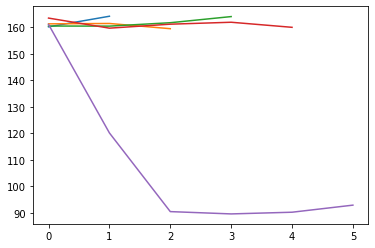

In [42]:
def get_line():
    for i in range(2, 7):
        s = pd.Series(total_cpu[i][0])
        s.plot.line()
get_line()

In [13]:
from concurrent.futures import ProcessPoolExecutor

total_cpu = {}
for i in range(1, 31):
    result = []
    
    def full(title='20 CPU'):
        s = 0
        s += en_ru(title)
        s += ar_ru(title)
        result.append(s)
    
    cmd = "full()," * i
    
    start = time.time() # начало замера времени
    def main():    
        with ProcessPoolExecutor(16) as executor:
            executor.submit(eval(cmd))
    main()
    end = time.time() # окончание замера времени
    
    unit = sum(result) / len(result)
    func = (end - start) / i
    total_cpu[i] = [result, end - start]
    
    print(i, unit, func)

1 159.49060034751892 159.63252711296082
2 162.17841744422913 162.2359161376953
3 160.74113821983337 160.7818122704824
4 161.67622530460358 161.70897084474564
5 161.24706621170043 161.27385978698732
6 107.36839465300243 107.39256207148235
7 91.10729711396354 91.13157616342816
8 90.04848247766495 90.06911164522171
9 91.35645673010085 91.37578135066562
10 90.46744546890258 90.48644127845765
11 90.9678032614968 90.98481843688272
12 90.52091467380524 90.53831923007965
13 89.96947378378648 89.9859556051401
14 89.96466042314258 89.98022680623191
15 89.60757664044698 89.6232977549235
16 92.36196208000183 92.37696382403374
17 92.81427339946522 92.82886216219734
18 92.04563068019019 92.06040297614203
19 93.32356293577897 93.33719741670708
20 90.26961340904236 90.28315988779067
21 90.27342294511341 90.28698740686688
22 90.25108919360422 90.26599717140198
23 90.58942420586295 90.60234859715338
24 90.12958364685376 90.14248822132747
25 90.68874969482422 90.70158345222472
26 90.35830616950989 90.370

In [14]:
total_cpu

{1: [[159.49060034751892], 159.63252711296082],
 2: [[160.1816530227661, 164.17518186569214], 324.4718322753906],
 3: [[161.30426740646362, 161.4458305835724, 159.4733166694641],
  482.34543681144714],
 4: [[160.4796917438507,
   160.44638776779175,
   161.7325258255005,
   164.04629588127136],
  646.8358833789825],
 5: [[163.47657871246338,
   159.67828059196472,
   161.1767966747284,
   161.90909075737,
   159.9945843219757],
  806.3692989349365],
 6: [[161.08648324012756,
   120.11789059638977,
   90.4171495437622,
   89.54526162147522,
   90.18544125556946,
   92.85814166069031],
  644.355372428894],
 7: [[91.8123025894165,
   90.58397793769836,
   90.38024854660034,
   90.70189094543457,
   92.14565062522888,
   91.63154578208923,
   90.49546337127686],
  637.9210331439972],
 8: [[89.35428094863892,
   90.98738598823547,
   90.27152633666992,
   90.39403057098389,
   89.43973350524902,
   90.3449387550354,
   90.07801651954651,
   89.51794719696045],
  720.5528931617737],
 9: [[90

In [16]:
example = [89.27440333366394,
   90.04111170768738,
   90.46153330802917,
   90.10521054267883,
   91.58933806419373,
   90.24916911125183,
   90.76436018943787,
   90.41460275650024,
   90.98737096786499,
   91.10406303405762,
   90.94552516937256,
   90.17714142799377,
   89.65137648582458,
   90.71472144126892,
   89.98464393615723,
   90.90110516548157,
   90.611487865448,
   91.62718439102173,
   90.1641743183136,
   91.44483184814453,
   91.58886051177979,
   91.16152381896973,
   90.49533867835999,
   92.08522462844849,
   92.88402533531189,
   90.64805603027344,
   90.99148106575012,
   91.65907454490662,
   91.4153823852539,
   92.4824116230011
]

In [21]:
import pandas as pd
pd.DataFrame(example).line()

AttributeError: 'DataFrame' object has no attribute 'line'

<AxesSubplot:>

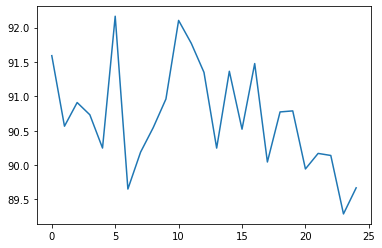

In [31]:
s = pd.Series(total_cpu[25][0])
s.plot.line()

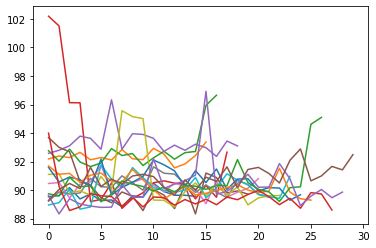

In [36]:
def get_line():
    for i in range(15, 31):
        s = pd.Series(total_cpu[i][0])
        s.plot.line()
get_line()